# Decision Value in Football  
## Evaluating On-Ball Decision Quality Using Expected Threat (xT)
### Bundesliga 2023/24 Analysis




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsbombpy import sb


In [2]:
matches = sb.matches(competition_id=9, season_id=281)
matches[["match_id", "home_team", "away_team", "match_date"]].head()


C:\Users\rossc\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,match_id,home_team,away_team,match_date
0,3895302,Bayer Leverkusen,Werder Bremen,2024-04-14
1,3895292,Union Berlin,Bayer Leverkusen,2024-04-06
2,3895333,Eintracht Frankfurt,Bayer Leverkusen,2024-05-05
3,3895340,Bochum,Bayer Leverkusen,2024-05-12
4,3895348,Bayer Leverkusen,Augsburg,2024-05-18


In [3]:
all_events = []

for match_id in matches["match_id"]:
    ev = sb.events(match_id=match_id)
    ev["match_id"] = match_id
    all_events.append(ev)

events = pd.concat(all_events, ignore_index=True)

events.head()


C:\Users\rossc\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
C:\Users\rossc\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
C:\Users\rossc\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
C:\Users\rossc\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
C:\Users\rossc\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
C:\Users\rossc\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
C:\Users\rossc\anaconda3\Lib\site-packages\statsbomb

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,...,pass_straight,shot_open_goal,dribble_no_touch,goalkeeper_shot_saved_off_target,shot_saved_off_target,goalkeeper_shot_saved_to_post,shot_saved_to_post,clearance_other,goalkeeper_success_out,goalkeeper_success_in_play
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
events.shape

(137765, 111)

In [5]:
events["type"].value_counts().head(15)
passes = events[events["type"] == "Pass"][["match_id","team","player","minute","second","location","pass_end_location","pass_outcome"]].head(10)
carries = events[events["type"] == "Carry"][["match_id","team","player","minute","second","location","carry_end_location"]].head(10)

passes, carries


(    match_id              team           player  minute  second      location  \
 6    3895302     Werder Bremen   Nick Woltemade       0       3  [61.0, 40.1]   
 7    3895302     Werder Bremen   Marvin Ducksch       0       4  [59.0, 40.6]   
 8    3895302     Werder Bremen   Christian Groß       0       7  [35.1, 43.7]   
 9    3895302     Werder Bremen  Julián Malatini       0      10  [32.7, 65.3]   
 10   3895302     Werder Bremen  Mitchell Weiser       0      11  [44.5, 77.5]   
 11   3895302     Werder Bremen   Nick Woltemade       0      13  [58.3, 66.0]   
 12   3895302     Werder Bremen  Mitchell Weiser       0      14  [53.5, 70.0]   
 13   3895302     Werder Bremen   Marvin Ducksch       0      16  [66.4, 63.8]   
 14   3895302     Werder Bremen  Mitchell Weiser       0      17  [62.7, 55.2]   
 15   3895302  Bayer Leverkusen     Nathan Tella       0      19  [33.3, 43.2]   
 
    pass_end_location pass_outcome  
 6       [59.0, 40.9]          NaN  
 7       [35.1, 43.2] 

In [8]:
# xT grid (12 x 8)
# Values increase as you move towards the opponent goal (right side)
XT_GRID = np.array([
    [0.001, 0.002, 0.003, 0.004, 0.004, 0.003, 0.002, 0.001],
    [0.002, 0.003, 0.005, 0.007, 0.007, 0.005, 0.003, 0.002],
    [0.003, 0.005, 0.008, 0.012, 0.012, 0.008, 0.005, 0.003],
    [0.004, 0.007, 0.012, 0.018, 0.018, 0.012, 0.007, 0.004],
    [0.006, 0.010, 0.017, 0.026, 0.026, 0.017, 0.010, 0.006],
    [0.009, 0.015, 0.025, 0.038, 0.038, 0.025, 0.015, 0.009],
    [0.013, 0.022, 0.036, 0.055, 0.055, 0.036, 0.022, 0.013],
    [0.019, 0.031, 0.051, 0.078, 0.078, 0.051, 0.031, 0.019],
    [0.027, 0.044, 0.072, 0.110, 0.110, 0.072, 0.044, 0.027],
    [0.038, 0.061, 0.100, 0.152, 0.152, 0.100, 0.061, 0.038],
    [0.052, 0.084, 0.138, 0.208, 0.208, 0.138, 0.084, 0.052],
    [0.070, 0.112, 0.182, 0.270, 0.270, 0.182, 0.112, 0.070],
])

def xt_value(x, y):
    """
    StatsBomb pitch: 120 x 80
    """
    if pd.isna(x) or pd.isna(y):
        return np.nan

    x = np.clip(x, 0, 120)
    y = np.clip(y, 0, 80)

    x_bin = int(x / 120 * XT_GRID.shape[0])
    y_bin = int(y / 80 * XT_GRID.shape[1])

    x_bin = min(x_bin, XT_GRID.shape[0] - 1)
    y_bin = min(y_bin, XT_GRID.shape[1] - 1)

    return XT_GRID[x_bin, y_bin]


In [9]:
# Keep only passes and carries
actions = events[events["type"].isin(["Pass", "Carry"])].copy()

# Start location
actions["x_start"] = actions["location"].apply(lambda v: v[0] if isinstance(v, list) else np.nan)
actions["y_start"] = actions["location"].apply(lambda v: v[1] if isinstance(v, list) else np.nan)

# End location depends on event type
actions["x_end"] = np.nan
actions["y_end"] = np.nan

pass_mask = actions["type"] == "Pass"
actions.loc[pass_mask, "x_end"] = actions.loc[pass_mask, "pass_end_location"].apply(
    lambda v: v[0] if isinstance(v, list) else np.nan
)
actions.loc[pass_mask, "y_end"] = actions.loc[pass_mask, "pass_end_location"].apply(
    lambda v: v[1] if isinstance(v, list) else np.nan
)

carry_mask = actions["type"] == "Carry"
actions.loc[carry_mask, "x_end"] = actions.loc[carry_mask, "carry_end_location"].apply(
    lambda v: v[0] if isinstance(v, list) else np.nan
)
actions.loc[carry_mask, "y_end"] = actions.loc[carry_mask, "carry_end_location"].apply(
    lambda v: v[1] if isinstance(v, list) else np.nan
)

# xT at start and end
actions["xt_start"] = actions.apply(lambda r: xt_value(r["x_start"], r["y_start"]), axis=1)
actions["xt_end"] = actions.apply(lambda r: xt_value(r["x_end"], r["y_end"]), axis=1)

# Decision value
actions["xt_added"] = actions["xt_end"] - actions["xt_start"]

# Pass completion flag (carry is always "completed")
actions["completed"] = np.where(
    actions["type"] == "Pass",
    actions["pass_outcome"].isna(),
    True
)

# Clean up
actions = actions.dropna(subset=["xt_added", "x_start", "x_end"]).reset_index(drop=True)

actions[["match_id","team","player","type","minute","second","completed","xt_added"]].head(10)


,match_id,team,player,type,minute,second,completed,xt_added
0,3895302,Werder Bremen,Nick Woltemade,Pass,0,3,True,-0.017
1,3895302,Werder Bremen,Marvin Ducksch,Pass,0,4,True,-0.020
2,3895302,Werder Bremen,Christian Groß,Pass,0,7,True,-0.011
3,3895302,Werder Bremen,Julián Malatini,Pass,0,10,True,-0.001
4,3895302,Werder Bremen,Mitchell Weiser,Pass,0,11,True,0.016
5,3895302,Werder Bremen,Nick Woltemade,Pass,0,13,True,-0.006
6,3895302,Werder Bremen,Mitchell Weiser,Pass,0,14,True,0.013
7,3895302,Werder Bremen,Marvin Ducksch,Pass,0,16,True,0.014
8,3895302,Werder Bremen,Mitchell Weiser,Pass,0,17,False,0.074
9,3895302,Bayer Leverkusen,Nathan Tella,Pass,0,19,True,-0.014


In [10]:
actions.sort_values("xt_added", ascending=False)[
    ["match_id","team","player","type","minute","second","completed","xt_added","x_start","y_start","x_end","y_end"]
].head(15)


,match_id,team,player,type,minute,second,completed,xt_added,x_start,y_start,x_end,y_end
66004,3895067,Darmstadt 98,Christoph Klarer,Pass,66,18,False,0.264,47.1,72.7,110.6,32.9
66065,3895067,Bayer Leverkusen,Alejandro Grimaldo García,Pass,72,19,False,0.255,56.4,14.8,110.3,35.3
25454,3895121,Freiburg,Matthias Ginter,Pass,53,45,False,0.251,73.6,71.5,110.5,42.6
56913,3895158,Borussia Dortmund,Marius Wolf,Pass,12,15,False,0.251,70.7,76.4,112.9,42.0
67496,3895060,Borussia Mönchengladbach,Franck Honorat,Pass,13,48,False,0.251,79.7,72.9,111.2,32.4
40041,3895258,Bayer Leverkusen,Alejandro Grimaldo García,Pass,26,47,False,0.251,70.4,7.9,114.8,35.9
36290,3895320,VfB Stuttgart,Hiroki Ito,Pass,35,12,False,0.248,64.3,10.1,111.6,36.3
8082,3895348,Bayer Leverkusen,Odilon Kossonou,Pass,22,35,False,0.248,64.4,62.7,110.4,36.5
26992,3895107,Bayer Leverkusen,Jonas Hofmann,Pass,15,55,True,0.243,87.2,9.3,113.8,45.0
36584,3895320,Bayer Leverkusen,Alejandro Grimaldo García,Pass,60,6,False,0.243,84.5,7.4,111.6,43.6


In [11]:
player_summary = (
    actions
    .groupby(["player", "team"])
    .agg(
        actions=("xt_added", "count"),
        total_xt=("xt_added", "sum"),
        avg_xt=("xt_added", "mean")
    )
    .reset_index()
    .sort_values("total_xt", ascending=False)
)

player_summary.head(15)


,player,team,actions,total_xt,avg_xt
3,Alejandro Grimaldo García,Bayer Leverkusen,3821,53.912,0.014109
106,Florian Wirtz,Bayer Leverkusen,3613,39.034,0.010804
145,Jeremie Frimpong,Bayer Leverkusen,2057,36.078,0.017539
149,Jonas Hofmann,Bayer Leverkusen,2730,34.493,0.012635
72,Edmond Fayçal Tapsoba,Bayer Leverkusen,3605,22.657,0.006285
284,Odilon Kossonou,Bayer Leverkusen,2638,16.909,0.006410
157,Josip Stanišić,Bayer Leverkusen,1978,13.291,0.006719
305,Piero Martín Hincapié Reyna,Bayer Leverkusen,2604,12.689,0.004873
112,Granit Xhaka,Bayer Leverkusen,6070,12.044,0.001984
87,Exequiel Alejandro Palacios,Bayer Leverkusen,3759,11.977,0.003186


In [12]:
player_summary["xt_per_action"] = player_summary["total_xt"] / player_summary["actions"]
player_summary.sort_values("xt_per_action", ascending=False).head(15)


,player,team,actions,total_xt,avg_xt,xt_per_action
146,Jessic Ngankam,FSV Mainz 05,2,0.168,0.084000,0.084000
98,Filip Stojilković,Darmstadt 98,6,0.401,0.066833,0.066833
334,Shio Fukuda,Borussia Mönchengladbach,6,0.289,0.048167,0.048167
89,Fabian Nürnberger,Darmstadt 98,9,0.426,0.047333,0.047333
344,Thomas Meunier,Borussia Dortmund,5,0.226,0.045200,0.045200
48,Christopher Antwi-Adjej,Bochum,29,1.269,0.043759,0.043759
263,Mërgim Berisha,Hoffenheim,3,0.127,0.042333,0.042333
224,Marius Bülter,Hoffenheim,85,3.138,0.036918,0.036918
340,Sven Michel,Augsburg,19,0.604,0.031789,0.031789
32,Benedict Hollerbach,Union Berlin,15,0.473,0.031533,0.031533


In [13]:
reliable = player_summary[player_summary["actions"] >= 300].copy()
reliable.sort_values("xt_per_action", ascending=False).head(15)
global_mean = player_summary["avg_xt"].mean()

reliable["xt_shrunk"] = (
    (reliable["actions"] * reliable["avg_xt"] + 300 * global_mean)
    / (reliable["actions"] + 300)
)

reliable.sort_values("xt_shrunk", ascending=False).head(15)


,player,team,actions,total_xt,avg_xt,xt_per_action,xt_shrunk
145,Jeremie Frimpong,Bayer Leverkusen,2057,36.078,0.017539,0.017539,0.016470
3,Alejandro Grimaldo García,Bayer Leverkusen,3821,53.912,0.014109,0.014109,0.013747
267,Nathan Tella,Bayer Leverkusen,704,10.095,0.014339,0.014339,0.012785
149,Jonas Hofmann,Bayer Leverkusen,2730,34.493,0.012635,0.012635,0.012289
106,Florian Wirtz,Bayer Leverkusen,3613,39.034,0.010804,0.010804,0.010676
9,Amine Adli,Bayer Leverkusen,888,9.512,0.010712,0.010712,0.010314
361,Victor Okoh Boniface,Bayer Leverkusen,917,7.464,0.008140,0.008140,0.008386
211,Lukáš Hrádecký,Bayer Leverkusen,1385,10.043,0.007251,0.007251,0.007587
157,Josip Stanišić,Bayer Leverkusen,1978,13.291,0.006719,0.006719,0.007038
257,Min Jae Kim,Bayern Munich,317,1.587,0.005006,0.005006,0.007015


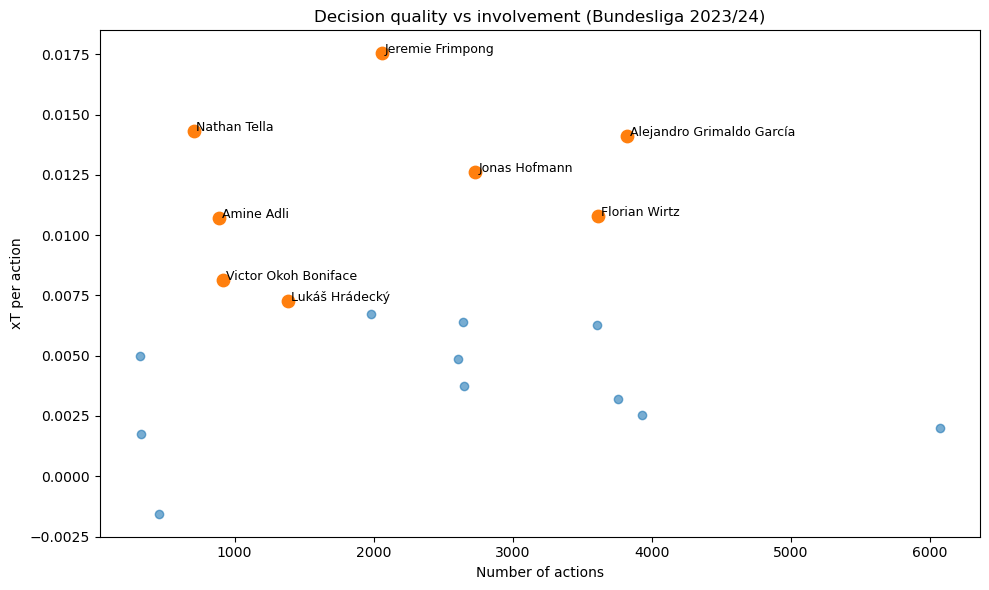

In [14]:
# Use the reliability filtered data
plot_df = reliable.copy()

plt.figure(figsize=(10, 6))

plt.scatter(
    plot_df["actions"],
    plot_df["xt_per_action"],
    alpha=0.6
)

# Highlight top players by shrunk score
top_players = plot_df.sort_values("xt_shrunk", ascending=False).head(8)

plt.scatter(
    top_players["actions"],
    top_players["xt_per_action"],
    s=80
)

for _, r in top_players.iterrows():
    plt.text(
        r["actions"] + 20,
        r["xt_per_action"],
        r["player"],
        fontsize=9
    )

plt.xlabel("Number of actions")
plt.ylabel("xT per action")
plt.title("Decision quality vs involvement (Bundesliga 2023/24)")

plt.tight_layout()
plt.show()

In [6]:
plt.tight_layout()
plt.savefig("decision_quality_vs_involvement.png", dpi=300)
plt.show()


<Figure size 640x480 with 0 Axes>